In [1090]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import time
import os

In [1091]:
#function to do color based segmentation
def combined (img):
    #b, g, r = cv2.split(img)
    b = img[:, :, 0]
    g = img[:, :, 1]
    r = img[:, :, 2]
    #r_max = g_max = b_max = 255
    r_max = np.amax(r)
    g_max = np.amax(g)
    b_max = np.amax(b)
    #print (r)
    #cv2.imshow("red chaneel",b)

    red_norm = r/r_max
    green_norm = g/g_max
    blue_norm = b/b_max

   # print(red_norm.shape)

    norm = red_norm + blue_norm + green_norm


    small_num = 0.0001
    r = red_norm/(norm+small_num)
    g = green_norm/(norm+small_num)
    b = blue_norm/(norm+small_num)

    #print('normalized r g b values: %d %d %d' %(r, g, b))

    ExG = 2*g - r - b #excess green

    #ExGR = ExG -1.4*r - g #excess green minus red

    #CIVE = 0.441*r - 0.811*g + 0.385*b + 18.78745 #color index of vegetation extraction

    #redistribute the weights without VEG
    #w_ExG = 0.28
    #w_ExGR = 0.34
    #w_CIVE = 0.38

    #combined = w_ExG * ExG + w_ExGR * ExGR + w_CIVE * CIVE

    return ExG

In [1092]:
def crop_center(img, cropx, cropy):
    y, x, _ = img.shape
    startx = x / 2 - (cropx / 2)
    starty = y / 2 - (cropy / 2)
    return img[int(starty):int(starty + cropy), int(startx):int(startx + cropx), :]

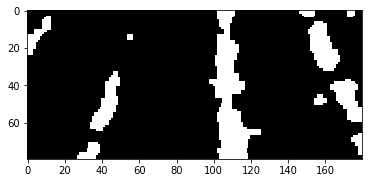

In [1093]:

#Load original image, in real case it will video frame
img = cv2.imread(r'C:\Users\khan1\jupyter_test_code\CRBD\Images\crop_row_230.jpg')
#img = cv2.imread(r'C:\Users\khan1\jupyter_test_code\IoU_test\TMGEM\tmgem_058.jpg')

#dim = (320,240) #(width,height)
#img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

height = img.shape[0]
width = img.shape[1]

#print(height)

cropx = 120
cropy = 80

#crop_img = crop_center(img,cropx,cropy)

#crop ROI

#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3+40 ):int(120+(width / 3))] #r-wsmall
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3):int(120+(width / 3))] #small
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3):int(120+(width / 3+20))] #big
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3-40):int(100+(width / 3))] #l-big
crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3 - 40):int(140+(width / 3))] #vbig
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3):int(180+(width / 3))] #r-vbig
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3 - 20):int(120+(width / 3 - 20))] #l-wsmall


img = crop_img
#plt.imshow(img)
max_value = np.max(combined(img))
min_value = np.min(combined(img))

###mapped combined image value (which is mostly negative) to 0-255
new_min = 0
new_max = 255
old_range = max_value - min_value
new_range = new_max - new_min
lin_map = (((combined(img).astype(np.float64) - min_value) * new_range) / old_range) + new_min
image_map = lin_map.astype(np.uint8)
###OTSU threshold
thresh_val,thresh_img = cv2.threshold(image_map,0,255,cv2.THRESH_OTSU)

###Morphology Opening-Closing to delete small weed segments
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

plt.imshow(closing, cmap='gray')
### all the white pixel coordinates in segemented image after noise clean

indices = np.where(closing == [255])
coordinates = list(zip(indices[0], indices[1]))


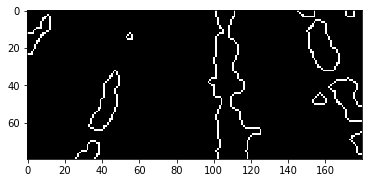

In [1094]:
edges = cv2.Canny(closing, 50, 200)
plt.imshow(edges, cmap='gray')

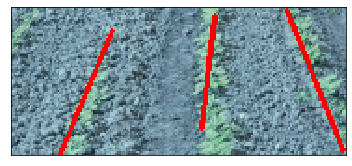

In [1095]:
threshold = 20

#hough_time = []

#for ii in range(0,1000):
    
    #start_time = time.time()

###   threshold, which means minimum vote it should get for it to be considered as a line.
###   minLineLength - Minimum length of line. Line segments shorter than this are rejected.
###   maxLineGap - Maximum allowed gap between line segments to treat them as single line.
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=threshold, minLineLength=60, maxLineGap=80)

row_width = 10
lines_o = lines.T
#print(lines_o[:,0][0])
xpos = lines_o[:,0][0]
#print(len(xpos))
del_lines_pos = []
for i in range(0,len(xpos)-1):
    for j in range(i+1,len(xpos)):
        diff = np.abs(xpos[i] - xpos [j])
        #print("diff",diff)
        if (diff < row_width):
            delete = i
            del_lines_pos.append(delete)
    #print("delted pos",del_lines_pos)


# Draw lines on the image
counter = 0
for line in lines:
    #print("line",line[0])
    x1, y1, x2, y2 = line[0]
    #print("x1",x1,"y1",y1,"x2",x2,"y2",y2)
    tangent_angle = np.abs(math.degrees(math.atan2(y2-y1, x2-x1)))

    if ((any(counter == item for item in del_lines_pos)) or (tangent_angle <= 40)): ## angle lower than this rejected
        pass                                                                        ## higher angle means needs to be straighter lines

    else:
        tangent_angle = np.abs(math.degrees(math.atan2(y2-y1, x2-x1)))
        #print("line tangent degree",tangent_angle)
        #point1 = cv2.circle(img,(x1,y1), 1, (0,0,255), 2)
        #point2 = cv2.circle(img,(x2,y2), 1, (0,0,255), 2)
        ht_line = cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    #plt.imshow(ht_line)
    counter = counter+1
        
#     end_time = time.time()
#     diff = end_time-start_time
#     hough_time.append(diff)

#print("runtime for hough transform: ",np.array(hough_time).mean())       

# Show result
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.imshow(ht_line)


#plt.savefig(r'C:\Users\khan1\jupyter_test_code\IoU_value\challenge_scene\hough_trans_challenge\hough_img230.png',bbox_inches='tight')
